In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
days = 3 * YEAR + 1
stats_interval = DAY

In [9]:
base_miner_factory = BaseMinerState.factory(balance=0)
burn_miner_factory = BurnShortfallMinerState.factory(balance=0, 
                                                     max_shortfall_fraction=0.50)
repay_miner_factory = RepayRatchetShortfallMinerState.factory(
                        balance=0.,
                        max_repayment_term=3. * YEAR,
                        max_fee_reward_fraction=0.25,
                        reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
                    )

def run_sim(x, miner_factory):
    initial_pledge_projection_period_days = x[0]
    supply_lock_target = x[1]

    network = dataclasses.replace(MAINNET_APR_2023,
        token_lease_fee=0.3,
        reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
        initial_pledge_projection_period_days=initial_pledge_projection_period_days,
        supply_lock_target=supply_lock_target
    )

    cfg_with_shortfall = SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=miner_factory,
    )
    cfg_without_shortfall = SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=miner_factory,
    )
    
    stats_with_shortfall = Simulator(cfg_with_shortfall).run_all(days, stats_interval)
    stats_without_shortfall = Simulator(cfg_without_shortfall).run_all(days, stats_interval)
    return stats_with_shortfall, stats_without_shortfall

In [10]:
base_stats_with_shortfall, base_stats_without_shortfall = run_sim(np.array([20.0, 0.3]), base_miner_factory)
burn_stats_with_shortfall, burn_stats_without_shortfall = run_sim(np.array([20.0, 0.3]), burn_miner_factory)
repay_stats_with_shortfall, repay_stats_without_shortfall = run_sim(np.array([20.0, 0.3]), repay_miner_factory)

# base_stats_with_shortfall_df = pd.DataFrame(data=base_stats_with_shortfall)
# base_stats_without_shortfall_df = pd.DataFrame(data=base_stats_without_shortfall)
burn_stats_with_shortfall_df = pd.DataFrame(data=burn_stats_with_shortfall)
burn_stats_without_shortfall_df = pd.DataFrame(data=burn_stats_without_shortfall)
repay_stats_with_shortfall_df = pd.DataFrame(data=repay_stats_with_shortfall)
repay_stats_without_shortfall_df = pd.DataFrame(data=repay_stats_without_shortfall)

In [11]:
def compute_income(df):
    # assumes 75% of pledge is borrowed @ 25% AER
    # can update the cost model to other models
    
    pledge_borrowed = 0.75 * df['pledge_locked'].iloc[0]
    pledge_repayment_schedule = pledge_borrowed * np.exp(np.log(1+0.25) * df['day']/365.)
    costs = pledge_repayment_schedule - pledge_borrowed
    baseline_income = df['reward_earned'] - costs
    
    return baseline_income

Text(0.5, 0, 'days')

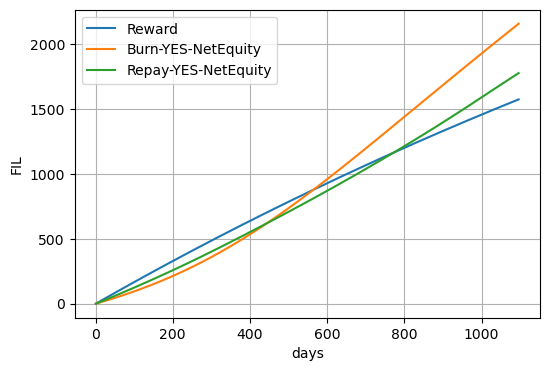

In [12]:
plt.figure(figsize=(6,4))

income_burn = compute_income(burn_stats_without_shortfall_df)
# income_repay = compute_income(repay_stats_without_shortfall_df)  # should be the same as above

# plt.plot(burn_stats_without_shortfall_df['day'], 
#          income_burn, 
#          label='No-(Reward-Cost[Borrow75%@25%AER])')
plt.plot(burn_stats_without_shortfall_df['day'], 
         burn_stats_without_shortfall_df['reward_earned'], 
         label='Reward')

plt.plot(burn_stats_with_shortfall_df['day'], 
         burn_stats_with_shortfall_df['net_equity'], 
         label='Burn-YES-NetEquity')

# plt.plot(repay_stats_without_shortfall_df['day'], 
#          income_repay, 
#          label='Repay-No-(Reward-Cost[Borrow75%@25%AER])')
plt.plot(repay_stats_with_shortfall_df['day'], 
         repay_stats_with_shortfall_df['net_equity'], 
         label='Repay-YES-NetEquity')

plt.legend()
plt.grid()
plt.ylabel('FIL')
plt.xlabel('days')